In [1]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
# import gensim
# from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
# import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
data['sentiment'].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [5]:
data = data[['selected_text', 'sentiment']]

In [6]:
data["selected_text"].fillna("No content", inplace = True)
data["selected_text"].isnull().sum()

0

In [7]:
def cleanData(data):
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
    # Remove new line characters
    data = re.sub('\s+', ' ', data)
    # Remove distracting single quotes
    data = re.sub("\'", "", data)       
    return data

In [8]:
temp = []
#Splitting pd.Series to list
data_to_list = data['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(cleanData(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [9]:
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

import string  # for punctuation handling

def sent_to_words(sentences):
    for sentence in sentences:
        # Convert to lowercase and remove punctuation
        cleaned_sentence = sentence.lower().translate(str.maketrans('', '', string.punctuation))
        # Split the sentence into words
        words = cleaned_sentence.split()
        yield words

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['id', 'have', 'responded', 'if', 'i', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'u', 'just', 'became', 'cooler']]


In [10]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [11]:
detoken = []
for i in range(len(data_words)):
    detoken.append(detokenize(data_words[i]))
print(detoken[:5])

['id have responded if i were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [12]:
detoken = np.array(detoken)

In [13]:
labels = np.array(data['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3)
del y

Machine Learning Models

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report


In [15]:
# Mapping sentiment labels to numerical values
label_mapping = {'neutral': 0, 'negative': 1, 'positive': 2}

# Convert sentiment labels to numerical values
y = np.array([label_mapping[label] for label in data['sentiment']])

In [16]:

# Splitting data into training and testing sets
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(detoken, y, test_size=0.2, random_state=42)

In [17]:
# Vectorizing text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_ml)
X_test_tfidf = tfidf_vectorizer.transform(X_test_ml)


In [18]:
# Training an SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train_ml)

SVC(kernel='linear')

In [19]:
y_pred = svm_model.predict(X_test_tfidf)
print(classification_report(y_test_ml, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2230
           1       0.83      0.80      0.82      1562
           2       0.92      0.82      0.87      1705

    accuracy                           0.85      5497
   macro avg       0.85      0.84      0.84      5497
weighted avg       0.85      0.85      0.85      5497



In [20]:
from sklearn.svm import SVC
import shap

explainer = shap.KernelExplainer(svm_model.predict, X_train_tfidf[:1000], max_evals=100, n_samples=50)

# Compute SHAP values for a subset of test data
X_test_subset = X_test_tfidf[:100]  
shap_values = explainer.shap_values(X_test_subset)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test_subset, feature_names=tfidf_vectorizer.get_feature_names_out())


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
 15%|█▌        | 15/100 [25:47:09<176:37:40, 7480.71s/it] 

In [ ]:
%pip install lime

In [ ]:
# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=label_encoder.classes_)

# Function to predict with BERT model
def predict_proba(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    return probs.numpy()

idx = 3
text_instance = df.loc[idx, 'cleaned_text']

# Explain an individual prediction
exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)

# Display explanation
exp.show_in_notebook(text=True)

In [ ]:
from sklearn.svm import SVC
import shap

# Train SVM model
# svm_model = SVC(kernel='linear')
# svm_model.fit(X_train_tfidf, y_train_ml)

# Create SHAP explainer
explainer = shap.KernelExplainer(svm_model.predict, X_train_tfidf)

# Reshape X_test_tfidf if explaining a single instance
# X_test_tfidf = X_test_tfidf.reshape(1, -1)  

# Compute SHAP values
shap_values = explainer.shap_values(X_test_tfidf)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test_tfidf, feature_names=tfidf_vectorizer.get_feature_names_out())


Using 21984 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/5497 [01:33<?, ?it/s]


MemoryError: Unable to allocate 10.7 GiB for an array with shape (22048, 130558) and data type int32

In [ ]:
X_test_tfidf = X_test_tfidf.reshape(1, -1)  


In [ ]:
X_train_dense = X_train_tfidf.toarray()  
X_test_dense = X_test_tfidf.toarray()   


In [ ]:
X_test_dense = X_test_dense.reshape(1, -1)  


In [ ]:
X_train_dense = X_train_tfidf.toarray() 
X_test_dense = X_test_tfidf.toarray()

X_test_dense = X_test_dense.reshape(1, -1) 

import shap
shap.initjs()

# Create SHAP KernelExplainer
# explainer = shap.Explainer(svm_model.predict, X_train_tfidf, feature_names=tfidf_vectorizer.get_feature_names_out())

# # Compute SHAP values
# shap_values = explainer(X_test_tfidf)
explainer = shap.Explainer(svm_model.predict, X_train_dense, feature_names=tfidf_vectorizer.get_feature_names_out())
shap_values = explainer(X_test_dense)

# explainer = shap.Explainer(svm_model.predict, X_train_tfidf, feature_names=tfidf_vectorizer.get_feature_names_out())
# shap_values = explainer(X_test_tfidf)

# Plot SHAP values for all instances
shap.plots.beeswarm(shap_values)

# Print SHAP values
print('SHAP Values for instance:')
print(shap_values)


DimensionError: The passed data does not match the background shape expected by the masker! The data of shape (87836563,) was passed while the masker expected data of shape (15979,).

In [ ]:
import shap
shap.initjs()

# Create SHAP KernelExplainer
explainer = shap.Explainer(svm_model, X_train_tfidf, feature_names=tfidf_vectorizer.get_feature_names_out())

# text_instance_idx = 10 
# text_instance = X_test_tfidf[text_instance_idx]
# print(X_test_ml[text_instance_idx])

# Compute SHAP values
shap_values = explainer(X_test_tfidf)
shap.plots.beeswarm(shap_values)

# Print SHAP values
print('SHAP Values for instance:')
print(shap_values)



ValueError: operands could not be broadcast together with shapes (5000,) (3,) 

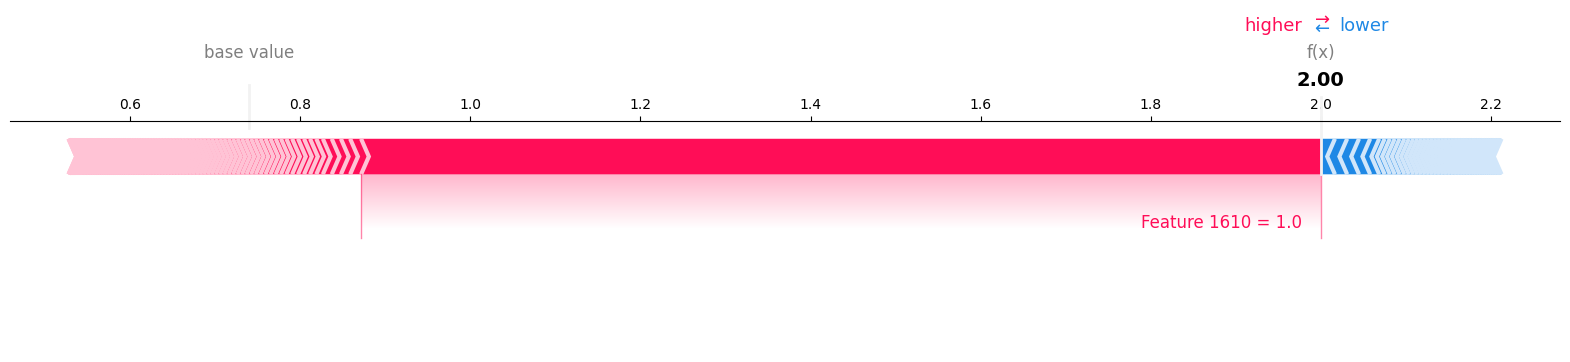

In [ ]:
import shap

# Initialize Javascript for visualization in Jupyter Notebook
shap.initjs()


text_instance_dense = X_test_tfidf[text_instance_idx].toarray()

# Plot force plot
shap.force_plot(explainer.expected_value, shap_values, text_instance_dense, matplotlib=True)



In [ ]:
import shap

shap.initjs()

# Create SHAP KernelExplainer
explainer = shap.Explainer(svm_model, X_train_tfidf, feature_names=tfidf_vectorizer.get_feature_names_out())

# text_instance_idx = 10 
# text_instance = X_test_tfidf[text_instance_idx]
# print(X_test_ml[text_instance_idx])

# Compute SHAP values
shap_values = explainer(X_test_tfidf)
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, X_test_tfidf, plot_type='bar')


ValueError: operands could not be broadcast together with shapes (5000,) (3,) 

In [ ]:
print(X_test_tfidf[text_instance_idx].shape)
print(shap_values.shape)

(1, 5000)
(1, 5000)


Deep Learning Models

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
import keras
import keras.preprocessing 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(detoken)
sequences = tokenizer.texts_to_sequences(detoken)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    1  124   46]
 [   0    0    0 ...    0  416   69]
 [   0    0    0 ...    0    0   14]
 ...
 [   0    0    0 ...  394   13    6]
 [   0    0    0 ...   28  569    8]
 [   0    0    0 ... 2454  199  690]]


In [ ]:
#Splitting the data
x_train, x_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(x_train),len(x_test),len(y_train),len(y_test))

20610 6871 20610 6871


In [ ]:
model = Sequential()
model.add(layers.Embedding(max_words, 20))
model.add(layers.LSTM(15,dropout=0.5))
model.add(layers.Dense(3,activation='softmax'))

model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test))

Epoch 1/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.5876 - loss: 0.9139 - val_accuracy: 0.7580 - val_loss: 0.6460
Epoch 2/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - accuracy: 0.7590 - loss: 0.6158 - val_accuracy: 0.7743 - val_loss: 0.5483
Epoch 3/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.7998 - loss: 0.5251 - val_accuracy: 0.7993 - val_loss: 0.5058
Epoch 4/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.8150 - loss: 0.4873 - val_accuracy: 0.8125 - val_loss: 0.4863
Epoch 5/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.8307 - loss: 0.4511 - val_accuracy: 0.8208 - val_loss: 0.4753
Epoch 6/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.8340 - loss: 0.4459 - val_accuracy: 0.8251 - val_loss: 0.4663
Epoch 7/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.8406 - loss: 0.4322 - val_accuracy: 0.8272 - val_loss: 0.4612
Epoch 8/10
645/645 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - accuracy: 0.8448 - loss: 0.4158 - 

In [ ]:
# Evaluate the model
from sklearn.metrics import classification_report, roc_auc_score

# Predict probabilities for test set
y_pred = model.predict(x_test)

# Convert probabilities to classes
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_test_classes, y_pred_classes))


215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
              precision    recall  f1-score   support

           0       0.80      0.87      0.84      2734
           1       0.79      0.79      0.79      1966
           2       0.91      0.81      0.86      2171

    accuracy                           0.83      6871
   macro avg       0.84      0.83      0.83      6871
weighted avg       0.83      0.83      0.83      6871



In [ ]:
explainer = shap.KernelExplainer(model.predict, x_train[:100])

text_instance_idx = 10 
text_instance = x_test[text_instance_idx]
print(x_test[text_instance_idx])

# Compute SHAP values
shap_values = explainer.shap_values(text_instance)

# Print SHAP values
print('SHAP Values for instance:')
print(shap_values)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   88  368   55  183    

In [ ]:
import shap

shap.initjs()


instance_idx = 10  
instance = x_test[instance_idx].tolist() 

feature_names = tokenizer.sequences_to_texts([instance])

# Print to debug
print(f"Number of features in feature_names: {len(feature_names)}")
print(feature_names)

# Plot force plot
# shap.force_plot(explainer.expected_value, shap_values[instance_idx], feature_names=feature_names)



Number of features in feature_names: 1
['how r u feeling and when r u guys coming back to come to vancouver']


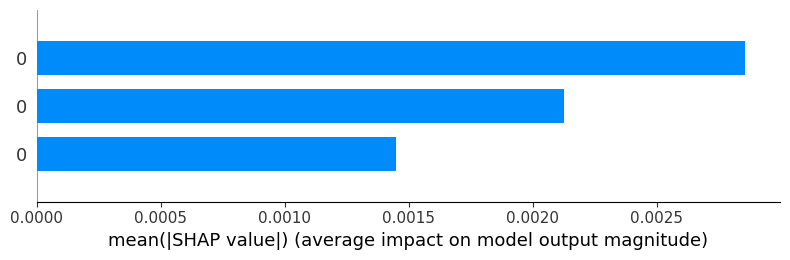

In [ ]:
import shap
shap.summary_plot(shap_values, text_instance, plot_type='bar')